In [16]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch.utils.data import DataLoader
from DatasetClass import KITTI_MOD_FIXED, ExtendedKittiMod, CarlaMotionSeg
from torch.nn import Sigmoid
import matplotlib.pyplot as plt


def get_dataloaders(dataset, batch_size=2, dataset_fraction=1.0, shuffle=True):
    dataset_length = int(len(dataset) * dataset_fraction)
    train_size = int(0.6 *  dataset_length)
    val_size = int(0.5*(dataset_length - train_size))
    test_size = dataset_length - train_size - val_size
    # taking subset of dataset according to dataset_fraction
    dataset_idx = list(range(0, dataset_length))
    dataset = torch.utils.data.Subset(dataset, dataset_idx)
    train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator = torch.Generator().manual_seed(0))
    train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=shuffle)
    return train_loader, val_loader, test_loader


def load_model(model_path, device='cuda:0'):
    if device == "cuda:0":
        # device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        if torch.cuda.is_available():
            device = torch.device(device)
            print("Moving model to GPU")
            return torch.load(model_path).to(device)
        else:
            print("No GPU available!")

    if device == "cpu":
        print("Model on CPU")
        return torch.load(model_path, map_location=lambda storage, loc: storage)


def calc_iou_moving(outputs: torch.Tensor, labels: torch.Tensor):
    SMOOTH = 1e-6
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1)
    
    intersection = torch.sum(torch.bitwise_and(outputs, labels).float(), (1,2))  # Will be zero if Truth=0 or Prediction=0
    union = torch.sum(torch.bitwise_or(outputs, labels).float(), (1,2))          # Will be zero if both are 0
    
    IoU = (intersection + SMOOTH) / (union + SMOOTH)   # avoid division by zero
    IoU = IoU.mean()
        
    return IoU

def calc_iou_background(outputs: torch.Tensor, labels: torch.Tensor):
    SMOOTH = 1e-6
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1)

    outputs = (outputs -1) * -1
    labels = (labels -1) * -1
    
    intersection = torch.sum(torch.bitwise_and(outputs, labels).float(), (1,2))  # Will be zero if Truth=0 or Prediction=0
    union = torch.sum(torch.bitwise_or(outputs, labels).float(), (1,2))          # Will be zero if both are 0
    
    IoU = (intersection + SMOOTH) / (union + SMOOTH)   # avoid division by zero
    IoU = IoU.mean()
        
    return IoU

def mIoU(outputs: torch.Tensor, labels: torch.Tensor):
    iou_moving = calc_iou_moving(outputs, labels)
    iou_background = calc_iou_background(outputs, labels)
    mIoU = (iou_moving + iou_background)/2
    return mIoU


def confusion_matrix(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1)
    labels = labels.squeeze(1)

    TP = torch.sum(torch.bitwise_and(outputs, labels).float(), (1,2)) # intersection
    FP = torch.sum(outputs,(1,2)) - TP
    FN = torch.sum(labels, (1,2)) - TP
    TN = torch.sum(labels, (1,2)) - torch.sum(torch.bitwise_or(outputs, labels).float(), (1,2)) # union

    return TP, FP, TN, FN

def aggregated_IoU(outputs, labels):
    SMOOTH = 1e-6
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1)
    
    intersection = torch.sum(torch.bitwise_and(outputs, labels).float(), (1,2))  # Will be zero if Truth=0 or Prediction=0
    union = torch.sum(torch.bitwise_or(outputs, labels).float(), (1,2))          # Will be zero if both are 0
    
    agg_IoU = (torch.sum(intersection, 0) + SMOOTH) / (torch.sum(union, 0) + SMOOTH)   # avoid division by zero
    return agg_IoU

   
def inference_prep(dataset_type="carla", model_type="carla", dataset_fraction=1.0, device="cuda:0"):
    if dataset_type == "carla":
        data_root = "/storage/remote/atcremers40/motion_seg/datasets/Carla_Annotation/Carla_Export/"
        dataset = CarlaMotionSeg(data_root)
    elif dataset_type == "kitti":
        data_root = "/storage/remote/atcremers40/motion_seg/datasets/Extended_MOD_Masks/"
        dataset = ExtendedKittiMod(data_root)
    if model == "carla":
        model_path = "/storage/remote/atcremers40/motion_seg/saved_models/02-02-2022_08-21_bs2/best_aIoU.pt"   # CARLA trained
        # model_path = "/storage/remote/atcremers40/motion_seg/saved_models/10-03-2022_19-42_bs2/best_aIoU.pt" # Carla BCE
    elif model == "kitti":
        model_path = "/storage/remote/atcremers40/motion_seg/saved_models/01-02-2022_18-30_bs2/best_aIoU.pt"  # KITTI trained
        # model_path = "/storage/remote/atcremers40/motion_seg/saved_models/12-03-2022_08-28_bs2/best_aIoU.pt" # KITTI BCE

    train_loader, val_loader, test_loader = get_dataloaders(dataset, dataset_fraction=dataset_fraction)
    model = load_model(model_path, device=device)
    return model, train_loader, val_loader, test_loader

def run_inference(model, loader, metric="IoU", device="cpu"):
    sigmoid = Sigmoid()
    device = torch.device(device)
    with torch.no_grad():
        model.eval()
        test_iou = []
        for idx, (data, targets) in enumerate(loader):
            data = data.to(device).float()
            targets = targets.to(device).int()

            # forward
            scores = model(data)
            scores_rounded = torch.round(sigmoid(scores)).int()
            if metric == "IoU":
                test_iou.append(calc_iou_moving(scores_rounded, targets))
            elif metric == "mIoU":
                test_iou.append(mIoU(scores_rounded, targets))
            elif metric == "AggIoU":
                test_iou.append(aggregated_IoU(scores_rounded, targets))

    print(f"{metric}: {sum(test_iou)/len(test_iou)}")


model, train_loader, val_loader, test_loader = inference_prep(dataset_type="carla", model_type="carla", dataset_fraction=1.0, device="cuda:0")
run_inference(model, test_loader, metric="mIoU", device="cuda:0")

dirs loaded:
['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025']
Moving model to GPU
mIoU: 0.8589369654655457


## Visualize sample images

First IoU: 0.9464514851570129
Second IoU: 1.0


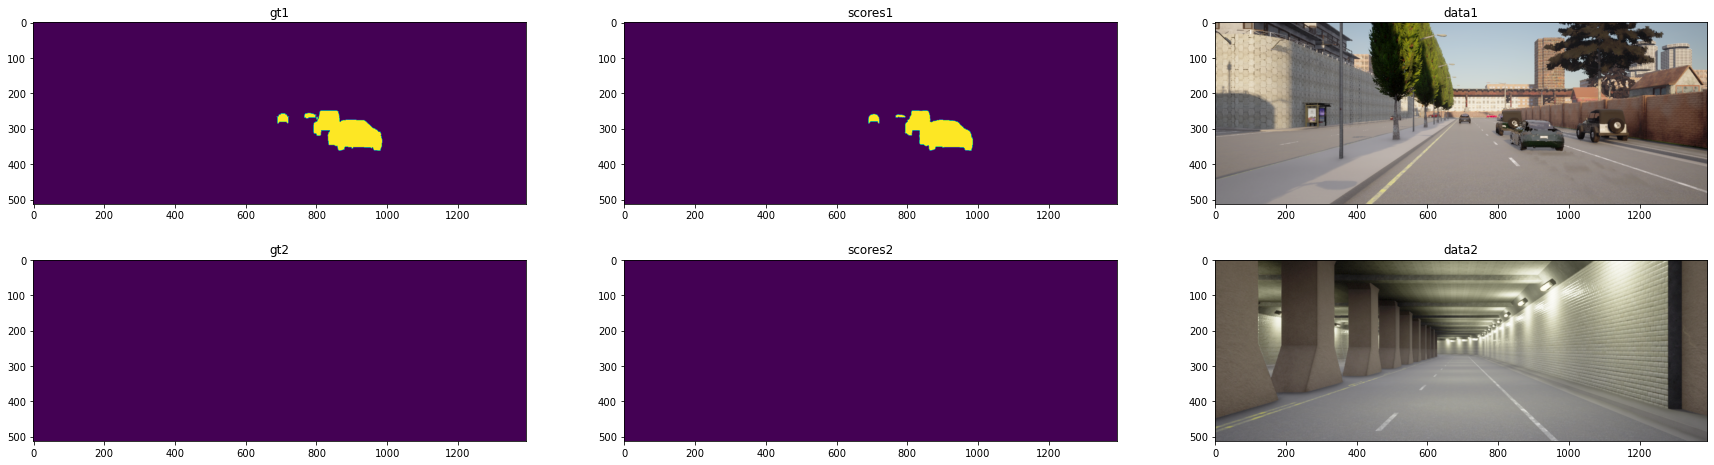

In [2]:
# model, train_loader, val_loader, test_loader = inference_prep(dataset_type="carla", dataset_fraction=0.1, device="cpu")

# get data from data_loader
device = torch.device("cpu")
data, targets = next(iter(test_loader))
data = data.to(device)
targets = targets.to(device)

# forward pass through NN
scores = model(data)

def vis_batch(scores, data, targets):
    # pass to CPU for visualization
    scores = scores.detach().cpu()
    targets = targets.detach().cpu().int()
    data = data.detach().cpu()
    sigmoid = Sigmoid()
    scores_rounded = torch.round(sigmoid(scores)).int()

    print(f"First IoU: {calc_iou_moving(scores_rounded[0], targets[0])}")
    print(f"Second IoU: {calc_iou_moving(scores_rounded[1], targets[1])}")

    # plotting
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(30, 8))
    ax1.imshow(targets[0][0])
    ax1.set_title("gt1")
    ax2.imshow(scores_rounded.detach().numpy()[0][0])
    ax2.set_title("scores1")
    ax3.imshow(np.transpose(data[0][:3], axes=[1, 2, 0]))
    ax3.set_title("data1")
    ax4.imshow(targets[1][0])
    ax4.set_title("gt2")
    ax5.imshow(scores_rounded.detach().numpy()[1][0])
    ax5.set_title("scores2")
    ax6.imshow(np.transpose(data[1][:3], axes=[1, 2, 0]))
    ax6.set_title("data2")
    plt.show()

vis_batch(scores, data, targets)

## Pre-computing mean and std of train set

In [23]:
import torch
from torch.utils.data import DataLoader
from DatasetClass import KITTI_MOD_FIXED, ExtendedKittiMod
import numpy as np

data_root = "/storage/remote/atcremers40/motion_seg/datasets/Extended_MOD_Masks/"
dataset = ExtendedKittiMod(data_root, test=False)
batch_size = 2
loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

channel_means = []
channel_std = []
for i,(data, _) in enumerate(loader):
    # calc mean
    channel_means.append([data[:,i,:,:].mean().item() for i in range(3)])
    # calc std
    channel_std.append([data[:,i,:,:].std().item() for i in range(3)])

mean = np.array(channel_means).sum(0)/len(channel_means)
std = np.array(channel_std).sum(0)/len(channel_std)
print(mean)
print(std)

dirs loaded:
['2011_09_26_drive_0005_sync', '2011_09_26_drive_0013_sync', '2011_09_26_drive_0014_sync', '2011_09_26_drive_0015_sync', '2011_09_26_drive_0018_sync', '2011_09_26_drive_0032_sync', '2011_09_26_drive_0051_sync', '2011_09_26_drive_0056_sync', '2011_09_26_drive_0057_sync', '2011_09_26_drive_0059_sync', '2011_09_26_drive_0060_sync']
[0.40637735 0.4300676  0.42383534]
[0.31099932 0.322008   0.33540214]
